Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

Загрузка датасета

In [2]:
hdata_loaded  = pd.read_csv("googleplaystore.csv")
print(hdata_loaded)

       Unnamed: 0                                                App  \
0               0     Photo Editor & Candy Camera & Grid & ScrapBook   
1               1                                Coloring book moana   
2               2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3               3                              Sketch - Draw & Paint   
4               4              Pixel Draw - Number Art Coloring Book   
...           ...                                                ...   
10836       10836                                   Sya9a Maroc - FR   
10837       10837                   Fr. Mike Schmitz Audio Teachings   
10838       10838                             Parkinson Exercices FR   
10839       10839                      The SCP Foundation DB fr nn5n   
10840       10840      iHoroscope - 2018 Daily Horoscope & Astrology   

                  Category  Rating Reviews                Size     Installs  \
0           ART_AND_DESIGN     4.1     159              

Устранение пропусков в данных

In [3]:
hdata = hdata_loaded
list(zip(hdata.columns, [i for i in hdata.dtypes]))

[('Unnamed: 0', dtype('int64')),
 ('App', dtype('O')),
 ('Category', dtype('O')),
 ('Rating', dtype('float64')),
 ('Reviews', dtype('O')),
 ('Size', dtype('O')),
 ('Installs', dtype('O')),
 ('Type', dtype('O')),
 ('Price', dtype('O')),
 ('Content Rating', dtype('O')),
 ('Genres', dtype('O')),
 ('Last Updated', dtype('O')),
 ('Current Ver', dtype('O')),
 ('Android Ver', dtype('O'))]

In [4]:
# Колонки с пропусками
hcols_with_na = [c for c in hdata.columns if hdata[c].isnull().sum() > 0]
hcols_with_na

['Rating', 'Type', 'Content Rating', 'Current Ver', 'Android Ver']

In [5]:
# Количество пропусков
[(c, hdata[c].isnull().sum()) for c in hcols_with_na]

[('Rating', 1474),
 ('Type', 1),
 ('Content Rating', 1),
 ('Current Ver', 8),
 ('Android Ver', 3)]

In [6]:
# Доля (процент) пропусков
[(c, hdata[c].isnull().mean()) for c in hcols_with_na]

[('Rating', 0.13596531685268887),
 ('Type', 9.224241306152569e-05),
 ('Content Rating', 9.224241306152569e-05),
 ('Current Ver', 0.0007379393044922055),
 ('Android Ver', 0.0002767272391845771)]

Заполнение показателями центра распределения и константой

In [7]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [8]:
all_data, filled_data, missed_data = impute_column(hdata, 'Rating', 'mean')
all_data

array([4.1       , 3.9       , 4.7       , ..., 4.19333832, 4.5       ,
       4.5       ])

In [9]:
filled_data

array([4.19333832, 4.19333832, 4.19333832, ..., 4.19333832, 4.19333832,
       4.19333832])

In [10]:
missed_data

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

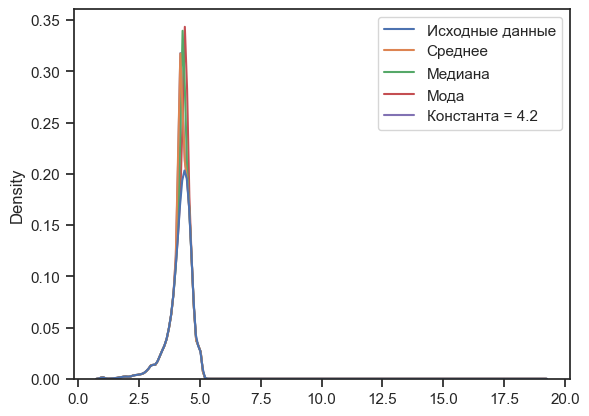

In [12]:
research_impute_numeric_column(hdata, 'Rating', 4.2)

In [13]:
knnimpute_cols = ['Unnamed: 0','Rating']
knnimpute_hdata = hdata[knnimpute_cols].copy()
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_hdata_imputed_temp = knnimputer.fit_transform(knnimpute_hdata)
knnimpute_hdata_imputed = pd.DataFrame(knnimpute_hdata_imputed_temp, columns=knnimpute_hdata.columns)
knnimpute_hdata_imputed.head()

,Unnamed: 0,Rating
0,0.0,4.1
1,1.0,3.9
2,2.0,4.7
3,3.0,4.5
4,4.0,4.3


In [14]:
# Пропуски заполнены
knnimpute_hdata_imputed.isnull().sum()

Unnamed: 0    0
Rating        0
dtype: int64

<AxesSubplot:ylabel='Density'>

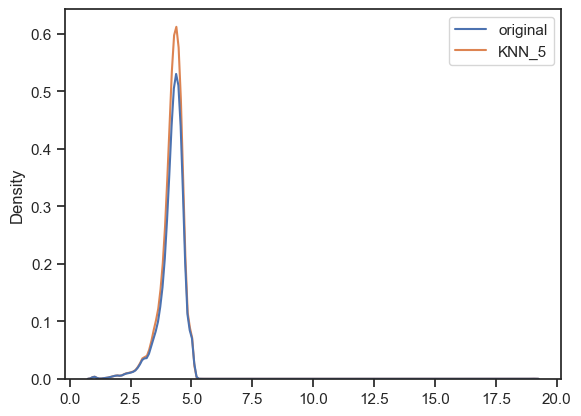

In [15]:
LotFrontage_df = pd.DataFrame({'original': knnimpute_hdata['Rating'].values})
LotFrontage_df['KNN_5'] = knnimpute_hdata_imputed['Rating']
sns.kdeplot(data=LotFrontage_df)

In [16]:
hdata_loaded['Rating'] = LotFrontage_df['KNN_5']
hcols_with_na = [c for c in hdata_loaded.columns if hdata_loaded[c].isnull().sum() > 0]
[(c, hdata_loaded[c].isnull().sum()) for c in hcols_with_na]

[('Type', 1), ('Content Rating', 1), ('Current Ver', 8), ('Android Ver', 3)]

In [17]:
hdata_loaded

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.900000,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700000,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,10836,Sya9a Maroc - FR,FAMILY,4.500000,38,53M,"5,000+",Free,0,Everyone,Education,25-Jul-17,1.48,4.1 and up
10837,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000000,4,3.6M,100+,Free,0,Everyone,Education,6-Jul-18,1,4.1 and up
10838,10838,Parkinson Exercices FR,MEDICAL,4.615385,3,9.5M,"1,000+",Free,0,Everyone,Medical,20-Jan-17,1,2.2 and up
10839,10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500000,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,19-Jan-15,Varies with device,Varies with device


In [18]:
hcols_with_na = [c for c in hdata_loaded.columns if hdata_loaded[c].isnull().sum() > 0]
[(c, hdata_loaded[c].isnull().sum()) for c in hcols_with_na]

[('Type', 1), ('Content Rating', 1), ('Current Ver', 8), ('Android Ver', 3)]

In [19]:
res = hdata_loaded.dropna(axis=0, how='any')

In [20]:
hcols_with_na = [c for c in res.columns if res[c].isnull().sum() > 0]
[(c, res[c].isnull().sum()) for c in hcols_with_na]

[]

Кодирование категориальных признаков

In [21]:
res

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.900000,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700000,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,10836,Sya9a Maroc - FR,FAMILY,4.500000,38,53M,"5,000+",Free,0,Everyone,Education,25-Jul-17,1.48,4.1 and up
10837,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000000,4,3.6M,100+,Free,0,Everyone,Education,6-Jul-18,1,4.1 and up
10838,10838,Parkinson Exercices FR,MEDICAL,4.615385,3,9.5M,"1,000+",Free,0,Everyone,Medical,20-Jan-17,1,2.2 and up
10839,10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500000,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,19-Jan-15,Varies with device,Varies with device


In [22]:
le1 = LabelEncoder()
cat_enc_le1 = le1.fit_transform(res['Category'])
res['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [23]:
np.unique(cat_enc_le1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [24]:
le1.inverse_transform([0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FAMILY',
       'FINANCE', 'FOOD_AND_DRINK', 'GAME', 'HEALTH_AND_FITNESS',
       'HOUSE_AND_HOME', 'LIBRARIES_AND_DEMO', 'LIFESTYLE',
       'MAPS_AND_NAVIGATION', 'MEDICAL', 'NEWS_AND_MAGAZINES',
       'PARENTING', 'PERSONALIZATION', 'PHOTOGRAPHY', 'PRODUCTIVITY',
       'SHOPPING', 'SOCIAL', 'SPORTS', 'TOOLS', 'TRAVEL_AND_LOCAL',
       'VIDEO_PLAYERS', 'WEATHER'], dtype=object)

In [25]:
k = 0
iterator = 0
for i in res['Size']:
    iterator = 0
    k = res[res['Size']==i].index[0]
    res['Size'][k] = res['Size'][k][:-1]
    res['Installs'][k] = res['Installs'][k][:-1]
    for j in res['Installs'][k]:
        if j == ',':
            res['Installs'][k] = res['Installs'][k][:iterator] + res['Installs'][k][iterator+1:]
            iterator -= 1
        iterator += 1

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [26]:
le2 = LabelEncoder()
cat_enc_le2 = le2.fit_transform(res['Type'])
res['Type'].unique()

array(['Free', 'Paid'], dtype=object)

In [27]:
le2.inverse_transform([0, 1])

array(['Free', 'Paid'], dtype=object)

In [28]:
le3 = LabelEncoder()
cat_enc_le3 = le3.fit_transform(res['Content Rating'])
res['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [29]:
le3.inverse_transform([0,  1,  2,  3,  4,  5])

array(['Adults only 18+', 'Everyone', 'Everyone 10+', 'Mature 17+',
       'Teen', 'Unrated'], dtype=object)

In [30]:
res = res.drop('App', axis = 1)
res = res.drop('Genres', axis = 1)
res = res.drop('Last Updated', axis = 1)
res = res.drop('Current Ver', axis = 1)
res = res.drop('Android Ver', axis = 1)
res

,Unnamed: 0,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,0,ART_AND_DESIGN,4.100000,159,19,10000,Free,0,Everyone
1,1,ART_AND_DESIGN,3.900000,967,14,500000,Free,0,Everyone
2,2,ART_AND_DESIGN,4.700000,87510,8.7,5000000,Free,0,Everyone
3,3,ART_AND_DESIGN,4.500000,215644,25,50000000,Free,0,Teen
4,4,ART_AND_DESIGN,4.300000,967,2.8,100000,Free,0,Everyone
...,...,...,...,...,...,...,...,...,...
10836,10836,FAMILY,4.500000,38,53,5000,Free,0,Everyone
10837,10837,FAMILY,5.000000,4,3.6,100,Free,0,Everyone
10838,10838,MEDICAL,4.615385,3,9.5,1000,Free,0,Everyone
10839,10839,BOOKS_AND_REFERENCE,4.500000,114,Varies with devic,1000,Free,0,Mature 17+


In [31]:
Categlist = res['Category'].unique().tolist()
for i in res['Category']:
    for j in Categlist:
        if i == j:
            k = res[res['Category']==i].index[0]
            res['Category'][k] = Categlist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
Typelist = res['Type'].unique().tolist()
for i in res['Type']:
    for j in Typelist:
        if i == j:
            k = res[res['Type']==i].index[0]
            res['Type'][k] = Typelist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
ContentRatinglist = res['Content Rating'].unique().tolist()
for i in res['Content Rating']:
    for j in ContentRatinglist:
        if i == j:
            k = res[res['Content Rating']==i].index[0]
            res['Content Rating'][k] = ContentRatinglist.index(j)

c:\users\aleka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
res

,Unnamed: 0,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,0,0,4.100000,159,19,10000,0,0,0
1,1,0,3.900000,967,14,500000,0,0,0
2,2,0,4.700000,87510,8.7,5000000,0,0,0
3,3,0,4.500000,215644,25,50000000,0,0,1
4,4,0,4.300000,967,2.8,100000,0,0,0
...,...,...,...,...,...,...,...,...,...
10836,10836,18,4.500000,38,53,5000,0,0,0
10837,10837,18,5.000000,4,3.6,100,0,0,0
10838,10838,19,4.615385,3,9.5,1000,0,0,0
10839,10839,3,4.500000,114,Varies with devic,1000,0,0,3


Нормализация числовых признаков

Сохранение для следующей работы

In [35]:
res

,Unnamed: 0,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,0,0,4.100000,159,19,10000,0,0,0
1,1,0,3.900000,967,14,500000,0,0,0
2,2,0,4.700000,87510,8.7,5000000,0,0,0
3,3,0,4.500000,215644,25,50000000,0,0,1
4,4,0,4.300000,967,2.8,100000,0,0,0
...,...,...,...,...,...,...,...,...,...
10836,10836,18,4.500000,38,53,5000,0,0,0
10837,10837,18,5.000000,4,3.6,100,0,0,0
10838,10838,19,4.615385,3,9.5,1000,0,0,0
10839,10839,3,4.500000,114,Varies with devic,1000,0,0,3


In [36]:
res.to_csv('googleplaystoreCleaned.csv')

In [37]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

In [38]:
res

,Unnamed: 0,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,0,0,4.100000,159,19,10000,0,0,0
1,1,0,3.900000,967,14,500000,0,0,0
2,2,0,4.700000,87510,8.7,5000000,0,0,0
3,3,0,4.500000,215644,25,50000000,0,0,1
4,4,0,4.300000,967,2.8,100000,0,0,0
...,...,...,...,...,...,...,...,...,...
10836,10836,18,4.500000,38,53,5000,0,0,0
10837,10837,18,5.000000,4,3.6,100,0,0,0
10838,10838,19,4.615385,3,9.5,1000,0,0,0
10839,10839,3,4.500000,114,Varies with devic,1000,0,0,3


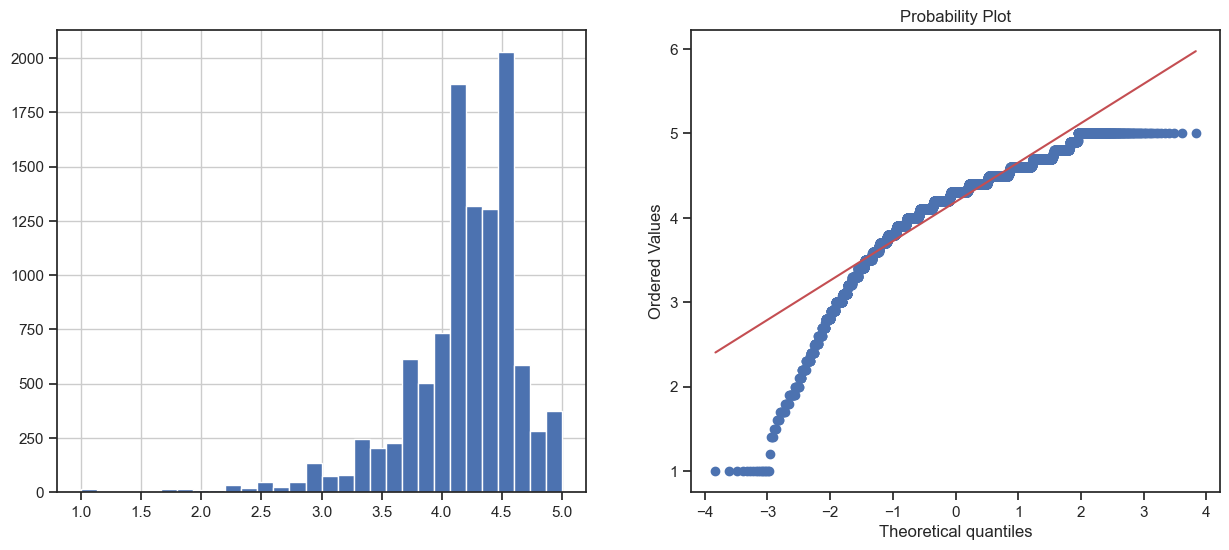

In [39]:
diagnostic_plots(res, 'Rating')

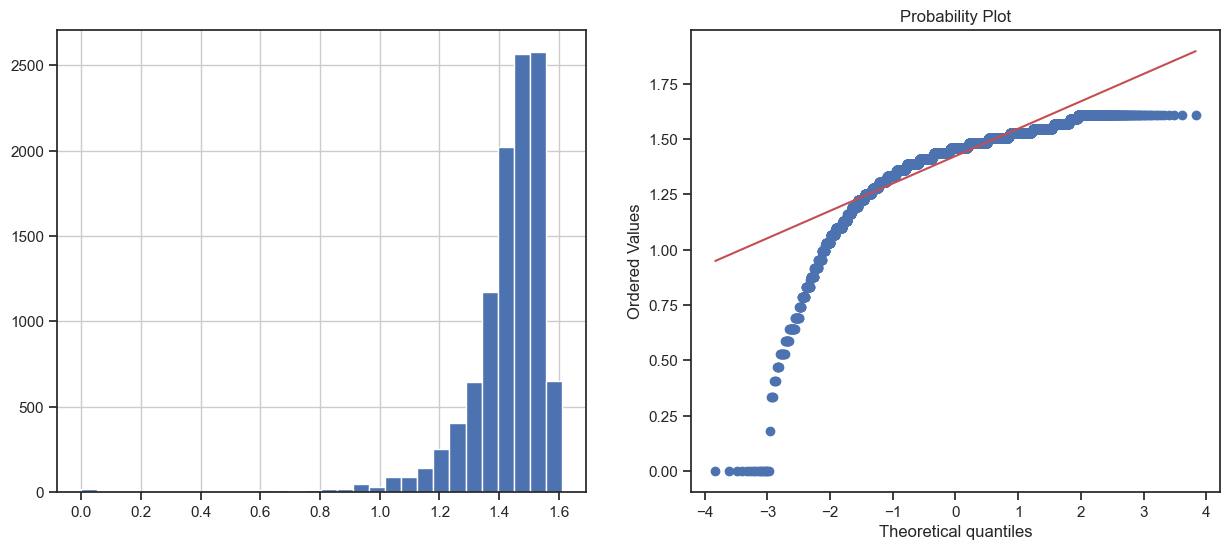

In [40]:
res['Rating_log'] = np.log(res['Rating'])
diagnostic_plots(res, 'Rating_log')

Оптимальное значение λ = 4.148617344099062


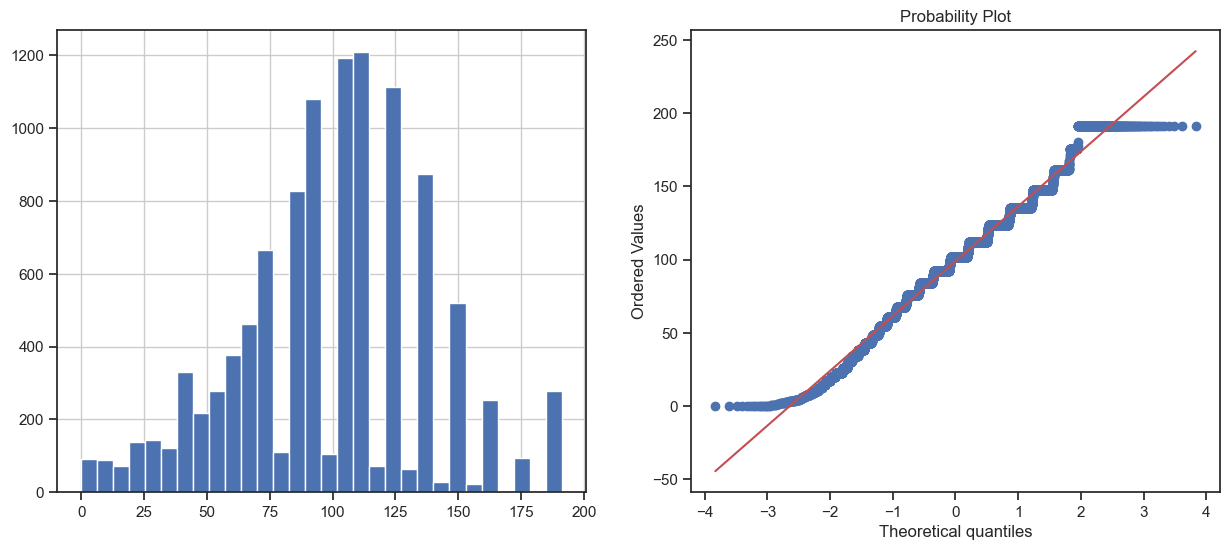

In [41]:
res['Rating_boxcox'], param = stats.boxcox(res['Rating']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(res, 'Rating_boxcox')

In [ ]:
for j in res['Size']:
    if j == 'Varies with devic':
        k = res[res['Size']==j].index[0]
        res['Size'][k] = res['Size'].mean